<a href="https://colab.research.google.com/github/codekali/Neural-SC-Desciptor/blob/master/firstTrial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [15]:
import torch
import json
from torch.utils.data import Dataset
dictionary={}
X,Y = [],[]
count=-1   
file=open("/content/drive/My Drive/Transformer/train/train.token.sbt")
for line in file:
  X.append(line)
  count+=1
count=0
file=open("/content/drive/My Drive/Transformer/train/train.token.nl")
for line in file:
  Y.append(line)
  count+=1
print(len(Y))
print(len(X))
X=X[0:100]
Y=Y[0:100]

445812
445812


In [16]:
# You can even put this data load operation in your Dataset class
import torch
import json
from torch.utils.data import Dataset
dictionary={}
X_valid,Y_valid = [],[]
count=-1   
file=open("/content/drive/My Drive/Transformer/val/valid.token.sbt")
for line in file:
  X_valid.append(line)
  count+=1
count=0
file=open("/content/drive/My Drive/Transformer/val/valid.token.nl")
for line in file:
  Y_valid.append(line)
  count+=1
print(len(Y_valid))
print(len(X_valid))
X_valid=X_valid[0:20]
Y_valid=Y_valid[0:20]

20000
20000


In [17]:
print(len(Y))
print(len(X))

100
100


In [0]:
import torch
from torch.utils import data

class Dataset(data.Dataset):
  def __init__(self, X_item, Y_item):
    self.X_item=X_item
    self.Y_item=Y_item

  def __len__(self):
    return len(self.X_item)

  def __getitem__(self, index):
    X = self.X_item[index]
    
    Y = self.Y_item[index]
    return X, Y

In [19]:
#import mydata
import torch
from torch.utils import data
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
params = {'batch_size': 5,
          'shuffle': True,
          'num_workers': 6}
max_epochs = 10

training_set = Dataset(X,Y)
training_generator = data.DataLoader(training_set, **params)

validation_set = Dataset(X_valid,Y_valid)
validation_generator = data.DataLoader(validation_set, **params)

cuda


In [20]:
!pip install transformers

In [0]:
# coding=utf-8
# Copyright 2018 The Google AI Language Team Authors and The HuggingFace Inc. team.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""PyTorch optimization for BERT model."""

import math
import torch
from torch.optim import Optimizer
from torch.optim.optimizer import required
from torch.nn.utils import clip_grad_norm_
import logging
import abc
import sys

logger = logging.getLogger(__name__)


if sys.version_info >= (3, 4):
    ABC = abc.ABC
else:
    ABC = abc.ABCMeta('ABC', (), {})


class _LRSchedule(ABC):
    """ Parent of all LRSchedules here. """
    warn_t_total = False        # is set to True for schedules where progressing beyond t_total steps doesn't make sense
    def __init__(self, warmup=0.002, t_total=-1, **kw):
        """
        :param warmup:  what fraction of t_total steps will be used for linear warmup
        :param t_total: how many training steps (updates) are planned
        :param kw:
        """
        super(_LRSchedule, self).__init__(**kw)
        if t_total < 0:
            logger.warning("t_total value of {} results in schedule not being applied".format(t_total))
        if not 0.0 <= warmup < 1.0 and not warmup == -1:
            raise ValueError("Invalid warmup: {} - should be in [0.0, 1.0[ or -1".format(warmup))
        warmup = max(warmup, 0.)
        self.warmup, self.t_total = float(warmup), float(t_total)
        self.warned_for_t_total_at_progress = -1

    def get_lr(self, step, nowarn=False):
        """
        :param step:    which of t_total steps we're on
        :param nowarn:  set to True to suppress warning regarding training beyond specified 't_total' steps
        :return:        learning rate multiplier for current update
        """
        if self.t_total < 0:
            return 1.
        progress = float(step) / self.t_total
        ret = self.get_lr_(progress)
        # warning for exceeding t_total (only active with warmup_linear
        if not nowarn and self.warn_t_total and progress > 1. and progress > self.warned_for_t_total_at_progress:
            logger.warning(
                "Training beyond specified 't_total'. Learning rate multiplier set to {}. Please set 't_total' of {} correctly."
                    .format(ret, self.__class__.__name__))
            self.warned_for_t_total_at_progress = progress
        # end warning
        return ret

    @abc.abstractmethod
    def get_lr_(self, progress):
        """
        :param progress:    value between 0 and 1 (unless going beyond t_total steps) specifying training progress
        :return:            learning rate multiplier for current update
        """
        return 1.


class ConstantLR(_LRSchedule):
    def get_lr_(self, progress):
        return 1.


class WarmupCosineSchedule(_LRSchedule):
    """
    Linearly increases learning rate from 0 to 1 over `warmup` fraction of training steps.
    Decreases learning rate from 1. to 0. over remaining `1 - warmup` steps following a cosine curve.
    If `cycles` (default=0.5) is different from default, learning rate follows cosine function after warmup.
    """
    warn_t_total = True
    def __init__(self, warmup=0.002, t_total=-1, cycles=.5, **kw):
        """
        :param warmup:      see LRSchedule
        :param t_total:     see LRSchedule
        :param cycles:      number of cycles. Default: 0.5, corresponding to cosine decay from 1. at progress==warmup and 0 at progress==1.
        :param kw:
        """
        super(WarmupCosineSchedule, self).__init__(warmup=warmup, t_total=t_total, **kw)
        self.cycles = cycles

    def get_lr_(self, progress):
        if progress < self.warmup:
            return progress / self.warmup
        else:
            progress = (progress - self.warmup) / (1 - self.warmup)   # progress after warmup
            return 0.5 * (1. + math.cos(math.pi * self.cycles * 2 * progress))


class WarmupCosineWithHardRestartsSchedule(WarmupCosineSchedule):
    """
    Linearly increases learning rate from 0 to 1 over `warmup` fraction of training steps.
    If `cycles` (default=1.) is different from default, learning rate follows `cycles` times a cosine decaying
    learning rate (with hard restarts).
    """
    def __init__(self, warmup=0.002, t_total=-1, cycles=1., **kw):
        super(WarmupCosineWithHardRestartsSchedule, self).__init__(warmup=warmup, t_total=t_total, cycles=cycles, **kw)
        assert(cycles >= 1.)

    def get_lr_(self, progress):
        if progress < self.warmup:
            return progress / self.warmup
        else:
            progress = (progress - self.warmup) / (1 - self.warmup)     # progress after warmup
            ret = 0.5 * (1. + math.cos(math.pi * ((self.cycles * progress) % 1)))
            return ret


class WarmupCosineWithWarmupRestartsSchedule(WarmupCosineWithHardRestartsSchedule):
    """
    All training progress is divided in `cycles` (default=1.) parts of equal length.
    Every part follows a schedule with the first `warmup` fraction of the training steps linearly increasing from 0. to 1.,
    followed by a learning rate decreasing from 1. to 0. following a cosine curve.
    """
    def __init__(self, warmup=0.002, t_total=-1, cycles=1., **kw):
        assert(warmup * cycles < 1.)
        warmup = warmup * cycles if warmup >= 0 else warmup
        super(WarmupCosineWithWarmupRestartsSchedule, self).__init__(warmup=warmup, t_total=t_total, cycles=cycles, **kw)

    def get_lr_(self, progress):
        progress = progress * self.cycles % 1.
        if progress < self.warmup:
            return progress / self.warmup
        else:
            progress = (progress - self.warmup) / (1 - self.warmup)     # progress after warmup
            ret = 0.5 * (1. + math.cos(math.pi * progress))
            return ret


class WarmupConstantSchedule(_LRSchedule):
    """
    Linearly increases learning rate from 0 to 1 over `warmup` fraction of training steps.
    Keeps learning rate equal to 1. after warmup.
    """
    def get_lr_(self, progress):
        if progress < self.warmup:
            return progress / self.warmup
        return 1.


class WarmupLinearSchedule(_LRSchedule):
    """
    Linearly increases learning rate from 0 to 1 over `warmup` fraction of training steps.
    Linearly decreases learning rate from 1. to 0. over remaining `1 - warmup` steps.
    """
    warn_t_total = True
    def get_lr_(self, progress):
        if progress < self.warmup:
            return progress / self.warmup
        return max((progress - 1.) / (self.warmup - 1.), 0.)


SCHEDULES = {
    None:       ConstantLR,
    "none":     ConstantLR,
    "warmup_cosine": WarmupCosineSchedule,
    "warmup_constant": WarmupConstantSchedule,
    "warmup_linear": WarmupLinearSchedule
}


class BertAdam(Optimizer):
    """Implements BERT version of Adam algorithm with weight decay fix.
    Params:
        lr: learning rate
        warmup: portion of t_total for the warmup, -1  means no warmup. Default: -1
        t_total: total number of training steps for the learning
            rate schedule, -1  means constant learning rate of 1. (no warmup regardless of warmup setting). Default: -1
        schedule: schedule to use for the warmup (see above).
            Can be `'warmup_linear'`, `'warmup_constant'`, `'warmup_cosine'`, `'none'`, `None` or a `_LRSchedule` object (see below).
            If `None` or `'none'`, learning rate is always kept constant.
            Default : `'warmup_linear'`
        b1: Adams b1. Default: 0.9
        b2: Adams b2. Default: 0.999
        e: Adams epsilon. Default: 1e-6
        weight_decay: Weight decay. Default: 0.01
        max_grad_norm: Maximum norm for the gradients (-1 means no clipping). Default: 1.0
    """
    def __init__(self, params, lr=required, warmup=-1, t_total=-1, schedule='warmup_linear',
                 b1=0.9, b2=0.999, e=1e-6, weight_decay=0.01, max_grad_norm=1.0, **kwargs):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {} - should be >= 0.0".format(lr))
        if not isinstance(schedule, _LRSchedule) and schedule not in SCHEDULES:
            raise ValueError("Invalid schedule parameter: {}".format(schedule))
        if not 0.0 <= b1 < 1.0:
            raise ValueError("Invalid b1 parameter: {} - should be in [0.0, 1.0[".format(b1))
        if not 0.0 <= b2 < 1.0:
            raise ValueError("Invalid b2 parameter: {} - should be in [0.0, 1.0[".format(b2))
        if not e >= 0.0:
            raise ValueError("Invalid epsilon value: {} - should be >= 0.0".format(e))
        # initialize schedule object
        if not isinstance(schedule, _LRSchedule):
            schedule_type = SCHEDULES[schedule]
            schedule = schedule_type(warmup=warmup, t_total=t_total)
        else:
            if warmup != -1 or t_total != -1:
                logger.warning("warmup and t_total on the optimizer are ineffective when _LRSchedule object is provided as schedule. "
                               "Please specify custom warmup and t_total in _LRSchedule object.")
        defaults = dict(lr=lr, schedule=schedule,
                        b1=b1, b2=b2, e=e, weight_decay=weight_decay,
                        max_grad_norm=max_grad_norm)
        self.rate = None
        super(BertAdam, self).__init__(params, defaults)

    def show_lr(self):
        return self.rate

    def get_lr(self):
        lr = []
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                if len(state) == 0:
                    return [0]
                lr_scheduled = group['lr']
                lr_scheduled *= group['schedule'].get_lr(state['step'])
                lr.append(lr_scheduled)
        return lr

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['next_m'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['next_v'] = torch.zeros_like(p.data)

                next_m, next_v = state['next_m'], state['next_v']
                beta1, beta2 = group['b1'], group['b2']

                # Add grad clipping
                if group['max_grad_norm'] > 0:
                    clip_grad_norm_(p, group['max_grad_norm'])

                # Decay the first and second moment running average coefficient
                # In-place operations to update the averages at the same time
                next_m.mul_(beta1).add_(1 - beta1, grad)
                next_v.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                update = next_m / (next_v.sqrt() + group['e'])

                # Just adding the square of the weights to the loss function is *not*
                # the correct way of using L2 regularization/weight decay with Adam,
                # since that will interact with the m and v parameters in strange ways.
                #
                # Instead we want to decay the weights in a manner that doesn't interact
                # with the m/v parameters. This is equivalent to adding the square
                # of the weights to the loss with plain (non-momentum) SGD.
                if group['weight_decay'] > 0.0:
                    update += group['weight_decay'] * p.data

                lr_scheduled = group['lr']
                lr_scheduled *= group['schedule'].get_lr(state['step'])

                self.rate = lr_scheduled

                update_with_lr = lr_scheduled * update
                p.data.add_(-update_with_lr)

                state['step'] += 1

                # step_size = lr_scheduled * math.sqrt(bias_correction2) / bias_correction1
                # No bias correction
                # bias_correction1 = 1 - beta1 ** state['step']
                # bias_correction2 = 1 - beta2 ** state['step']

        return loss


class Adam(Optimizer):
    """Implements pytorch version of Adam algorithm with weight decay fix.
    Params:
        lr: learning rate
        warmup: portion of t_total for the warmup, -1  means no warmup. Default: -1
        t_total: total number of training steps for the learning
            rate schedule, -1  means constant learning rate of 1. (no warmup regardless of warmup setting). Default: -1
        schedule: schedule to use for the warmup (see above).
            Can be `'warmup_linear'`, `'warmup_constant'`, `'warmup_cosine'`, `'none'`, `None` or a `_LRSchedule` object (see below).
            If `None` or `'none'`, learning rate is always kept constant.
            Default : `'warmup_linear'`
        b1: Adams b1. Default: 0.9
        b2: Adams b2. Default: 0.999
        e: Adams epsilon. Default: 1e-6
        weight_decay: Weight decay. Default: 0.01
        max_grad_norm: Maximum norm for the gradients (-1 means no clipping). Default: 1.0
    """
    def __init__(self, params, lr=required, warmup=-1, t_total=-1, schedule='warmup_linear',
                 b1=0.9, b2=0.999, e=1e-8, weight_decay=0,  amsgrad=False, max_grad_norm=1.0, **kwargs):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {} - should be >= 0.0".format(lr))
        if not isinstance(schedule, _LRSchedule) and schedule not in SCHEDULES:
            raise ValueError("Invalid schedule parameter: {}".format(schedule))
        if not 0.0 <= b1 < 1.0:
            raise ValueError("Invalid b1 parameter: {} - should be in [0.0, 1.0[".format(b1))
        if not 0.0 <= b2 < 1.0:
            raise ValueError("Invalid b2 parameter: {} - should be in [0.0, 1.0[".format(b2))
        if not e >= 0.0:
            raise ValueError("Invalid epsilon value: {} - should be >= 0.0".format(e))
        # initialize schedule object
        if not isinstance(schedule, _LRSchedule):
            schedule_type = SCHEDULES[schedule]
            schedule = schedule_type(warmup=warmup, t_total=t_total)
        else:
            if warmup != -1 or t_total != -1:
                logger.warning("warmup and t_total on the optimizer are ineffective when _LRSchedule object is provided as schedule. "
                               "Please specify custom warmup and t_total in _LRSchedule object.")
        defaults = dict(lr=lr, schedule=schedule,
                        b1=b1, b2=b2, e=e, weight_decay=weight_decay,
                        amsgrad=amsgrad, max_grad_norm=max_grad_norm)
        self.rate = None
        super(Adam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Adam, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    def show_lr(self):
        return self.rate

    def get_lr(self):
        lr = []
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                if len(state) == 0:
                    return [0]
                lr_scheduled = group['lr']
                lr_scheduled *= group['schedule'].get_lr(state['step'])
                lr.append(lr_scheduled)
        return lr

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['b1'], group['b2']

                # Add grad clipping
                if group['max_grad_norm'] > 0:
                    clip_grad_norm_(p, group['max_grad_norm'])

                lr_scheduled = group['lr']
                lr_scheduled *= group['schedule'].get_lr(state['step'])
                self.rate = lr_scheduled

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad.add_(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['e'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['e'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = lr_scheduled * math.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg, denom)

        return loss

class Adamax(Optimizer):
    """Implements Adamax algorithm (a variant of Adam based on infinity norm).
    It has been proposed in `Adam: A Method for Stochastic Optimization`__.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 2e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
    __ https://arxiv.org/abs/1412.6980
    """

    def __init__(self, params, lr=required, warmup=-1, t_total=-1, schedule='warmup_linear',
                 b1=0.9, b2=0.999, e=1e-8, weight_decay=0, max_grad_norm=1.0, **kwargs):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= e:
            raise ValueError("Invalid epsilon value: {}".format(e))
        if not 0.0 <= b1 < 1.0:
            raise ValueError("Invalid b1 parameter: {} - should be in [0.0, 1.0[".format(b1))
        if not 0.0 <= b2 < 1.0:
            raise ValueError("Invalid b2 parameter: {} - should be in [0.0, 1.0[".format(b2))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        if not isinstance(schedule, _LRSchedule):
            schedule_type = SCHEDULES[schedule]            
            schedule = schedule_type(warmup=warmup, t_total=t_total)
        else:
            if warmup != -1 or t_total != -1:
                logger.warning("warmup and t_total on the optimizer are ineffective when _LRSchedule object is provided as schedule. "
                               "Please specify custom warmup and t_total in _LRSchedule object.")

        defaults = dict(lr=lr, schedule=schedule,
                        b1=b1, b2=b2, e=e, weight_decay=weight_decay, max_grad_norm=max_grad_norm)
        self.rate = None
        super(Adamax, self).__init__(params, defaults)

    def show_lr(self):
        return self.rate

    def get_lr(self):
        lr = []
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                if len(state) == 0:
                    return [0]
                lr_scheduled = group['lr']
                lr_scheduled *= group['schedule'].get_lr(state['step'])
                lr.append(lr_scheduled)
        return lr

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adamax does not support sparse gradients')
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_inf'] = torch.zeros_like(p.data)

                exp_avg, exp_inf = state['exp_avg'], state['exp_inf']
                beta1, beta2 = group['b1'], group['b2']
                eps = group['e']

                # Add grad clipping
                if group['max_grad_norm'] > 0:
                    clip_grad_norm_(p, group['max_grad_norm'])

                lr_scheduled = group['lr']
                lr_scheduled *= group['schedule'].get_lr(state['step'])

                self.rate = lr_scheduled
                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Update biased first moment estimate.
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                # Update the exponentially weighted infinity norm.
                norm_buf = torch.cat([
                    exp_inf.mul_(beta2).unsqueeze(0),
                    grad.abs().add_(eps).unsqueeze_(0)
                ], 0)
                torch.max(norm_buf, 0, keepdim=False, out=(exp_inf, exp_inf.new().long()))

                bias_correction = 1 - beta1 ** state['step']
                clr = lr_scheduled / bias_correction

                p.data.addcdiv_(-clr, exp_avg, exp_inf)

        return loss

In [0]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch.optim as optim
import matplotlib.pyplot as plt

tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small')
model = model.to(device)
# optimizer should be defined outside training loop
# optimizer = optim.SGD(model.parameters(), lr=0.01)

In [0]:
num_epoch = 20
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_grouped_parameters = []
lr=2e-5
for key, value in dict(model.named_parameters()).items():
    if value.requires_grad:
        if any(nd in key for nd in no_decay):
            optimizer_grouped_parameters += [
                {"params": [value], "lr": lr, "weight_decay": 0.01}
            ]
        if not any(nd in key for nd in no_decay):
            optimizer_grouped_parameters += [
                {"params": [value], "lr": lr, "weight_decay": 0.0}
            ]
                
optimizer = BertAdam(
            optimizer_grouped_parameters,
            lr=lr,
            warmup=0.1,
            t_total=100,
#             t_total=num_epoch * len(training_generator),
            schedule='warmup_constant',
        )

In [32]:

loss_train = []
loss_valid = []
validloss = 0
for local_batch, local_labels in validation_generator:
    input_ids = tokenizer.batch_encode_plus(local_batch, return_tensors="pt",pad_to_max_length=True)
    label = tokenizer.batch_encode_plus(local_labels, return_tensors="pt",pad_to_max_length=True)
    model.eval()
    outputs = model(input_ids=(input_ids['input_ids']).to(device), lm_labels=(label['input_ids']).to(device))
    loss, prediction_scores = outputs[:2]
    validloss += loss
loss_valid.append(validloss / 4)

for epoch in range(num_epoch):
    trainloss=0
    validloss=0
    # Training
    for local_batch, local_labels in training_generator: 
        model.zero_grad()
        """Forward Function Implementation"""
        # Also, put the encode function in dataset. Return encoded matrix values from dataset. Here, only take it to gpu.
        input_ids = tokenizer.batch_encode_plus(local_batch, return_tensors="pt",pad_to_max_length=True)
        label = tokenizer.batch_encode_plus(local_labels, return_tensors="pt",pad_to_max_length=True)
        outputs = model(input_ids=(input_ids['input_ids']).to(device), lm_labels=(label['input_ids']).to(device),attention_mask=(input_ids['attention_mask']).to(device))
        loss, prediction_scores = outputs[:2]
        trainloss=loss
        """Forward Function Ends here"""
        loss_train.append(trainloss)
        """Loss and optimizer"""
        loss.backward()
        optimizer.step()
    


    """Validation"""
    with torch.set_grad_enabled(False):
        for local_batch, local_labels in validation_generator:
          input_ids = tokenizer.batch_encode_plus(local_batch, return_tensors="pt",pad_to_max_length=True)
          label = tokenizer.batch_encode_plus(local_labels, return_tensors="pt",pad_to_max_length=True)
          model.eval()
          outputs = model(input_ids=(input_ids['input_ids']).to(device), lm_labels=(label['input_ids']).to(device))
          loss, prediction_scores = outputs[:2]
          validloss += loss
    loss_valid.append(validloss / 4)
    print("\nEpoch ", epoch, " completed!, Training LOSS is: ", trainloss, " Validation loss is: ", validloss/4)
#plt.plot(loss_train)
#plt.plot(loss_valid)
    #print(loss, "\n\n")



Epoch  0  completed!, Training LOSS is:  tensor(3.9901, device='cuda:0', grad_fn=<NllLossBackward>)  Validation loss is:  tensor(18.1304, device='cuda:0')

Epoch  1  completed!, Training LOSS is:  tensor(2.9545, device='cuda:0', grad_fn=<NllLossBackward>)  Validation loss is:  tensor(14.5982, device='cuda:0')

Epoch  2  completed!, Training LOSS is:  tensor(2.2266, device='cuda:0', grad_fn=<NllLossBackward>)  Validation loss is:  tensor(20.4818, device='cuda:0')

Epoch  3  completed!, Training LOSS is:  tensor(3.3734, device='cuda:0', grad_fn=<NllLossBackward>)  Validation loss is:  tensor(16.8403, device='cuda:0')

Epoch  4  completed!, Training LOSS is:  tensor(3.1351, device='cuda:0', grad_fn=<NllLossBackward>)  Validation loss is:  tensor(19.6312, device='cuda:0')

Epoch  5  completed!, Training LOSS is:  tensor(2.7221, device='cuda:0', grad_fn=<NllLossBackward>)  Validation loss is:  tensor(19.8100, device='cuda:0')

Epoch  6  completed!, Training LOSS is:  tensor(2.4877, device=

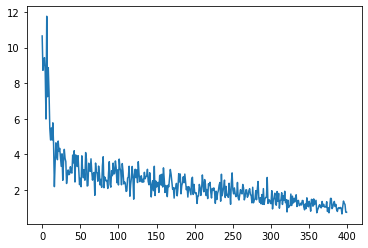

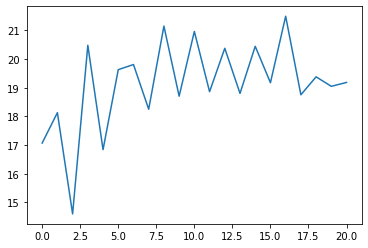

In [33]:
plt.plot(loss_train)
plt.show()
plt.plot(loss_valid)

In [0]:
 model.eval()

In [0]:
temp_index=50 
ip=tokenizer.encode(X[temp_index], return_tensors="pt")
op=model.generate(input_ids=ip.to(device))
print(tokenizer.decode(op[0]))
print(X[temp_index])
print(Y[temp_index])

creates an instance of the factory.
( ConstructorDeclaration ( StatementExpression ( SuperConstructorInvocation ) SuperConstructorInvocation ) StatementExpression ) ConstructorDeclaration

creates an instance of the factory .



In [0]:
from datetime import datetime as dt
runtime =  dt.now()
model_name = "/content/drive/My Drive/Transformer/models/" + runtime.strftime("%d:%m:%Y:%H:%M") + ".pth"

torch.save(model.state_dict(), model_name)